In [1]:
# Set up imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
import numpy as np
# Tools
import os
import joblib #per guardar el model de NN
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

**Llegim les dades per entrenar**

In [2]:
new = 'E:\TFG\Dades_Simulació'
os.chdir(new)

In [3]:
GOG = pd.read_csv('GOG_Simulation.csv') #Llegim l'arxiu amb les dades per entrenar (li posem NaN devant perque sabem que tenim NaN)

In [4]:
#['x','y','ra','dec','pmdec','pmra','phot_g_mean_mag', 'parallax','bp_rp']
GOG = GOG[['SourceId','x','y','mu_x','mu_y','phot_g_mean_mag','BP_RP', 'Varpi', 'Type']]

Eliminem les dades fora del rang de posicions que han de ser (errors de la simulació). Per a poder reportarlos els recollire primer a un DataFrame Anomenat **Errors**

In [5]:
Errors1 = GOG.drop(GOG[GOG['x']>-20].index)
Errors2 = GOG.drop(GOG[GOG['x']<20].index)
Errors3 = GOG.drop(GOG[GOG['y']<18].index)
Errors4 = GOG.drop(GOG[GOG['y']>-18].index)
Errors = pd.concat([Errors1,Errors2,Errors3,Errors4], ignore_index=True) 

In [6]:
Errors= Errors.sample(frac=1).reset_index(drop=True)
Errors.to_csv('errors.csv', index = False)   #Guardem les estrelles de fora del Rang per poder informar també

In [7]:
GOG = GOG.drop(GOG[GOG['x']<-20].index)   #Treiem les estrelles externes a la nostra regió perquè no contaminin
GOG = GOG.drop(GOG[GOG['x']>20].index)
GOG = GOG.drop(GOG[GOG['y']>18].index)
GOG = GOG.drop(GOG[GOG['y']<-18].index)

Barregem les dades per evitar preferencies posicionals de les dades

In [8]:
print(len(GOG))
GOG = GOG.dropna()
print(len(GOG))
GOG = GOG.sample(frac=1).reset_index(drop=True)

1201283
1201272


**Separem la columna que ens diu el tipus que es**

In [9]:
Type = GOG['Type'].to_numpy() #Passem la columna de tipus a un array
print('Columna de tipus', Type)
Train_GOG = GOG.copy()
Train_GOG = Train_GOG.drop(['Type','SourceId'], axis=1).to_numpy() #Pasem a array el dataset (menys Type)

Columna de tipus [0 0 0 ... 0 1 0]


In [10]:
Train_GOG

array([[-0.55278898, -3.21341226, -1.27362747, ..., 19.93881866,
         2.28576107,  1.48096599],
       [ 0.84043208,  5.0945623 ,  7.76133988, ..., 19.34875793,
         2.27935454,  2.23146901],
       [ 1.6733426 , -3.79745322, -2.4371562 , ..., 17.59948818,
         1.24921969,  0.82092679],
       ...,
       [-7.07719262, -2.10938981,  5.2693317 , ..., 19.89444526,
         1.39565162,  1.91206572],
       [-1.45221719, -0.68998851,  2.02070464, ..., 18.82198368,
         0.04511407, -0.26256265],
       [-0.66315051,  2.95685212, -3.16403259, ..., 18.61422551,
         1.03023418,  0.52755429]])

In [11]:
X = Train_GOG
y = Type

**Variables:** \
**trainX**  - array amb la informació de les estrelles que farem servir per entrenar \
**testX**   - array amb el tipus real de les estrelles que fem servir per entrenar   \
**trainy**  - array amb la informació de les estrelles que farem servir per testejar \
**testy**   - array amb el tipus real de les estrelles que fem servir per testejar

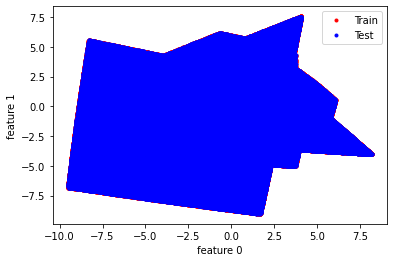

In [12]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)

plt.plot(trainX[:,0],trainX[:,1],"r.",label="Train")
plt.plot(testX[:,0],testX[:,1],"b.",label="Test")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
#plt.xlim(-20,20) #HE AFEGIT AIXO PER COMPRAVAR EL RANG CORRECTE
#plt.ylim(-18,18) # I AIXO
plt.legend()
p= plt.show()

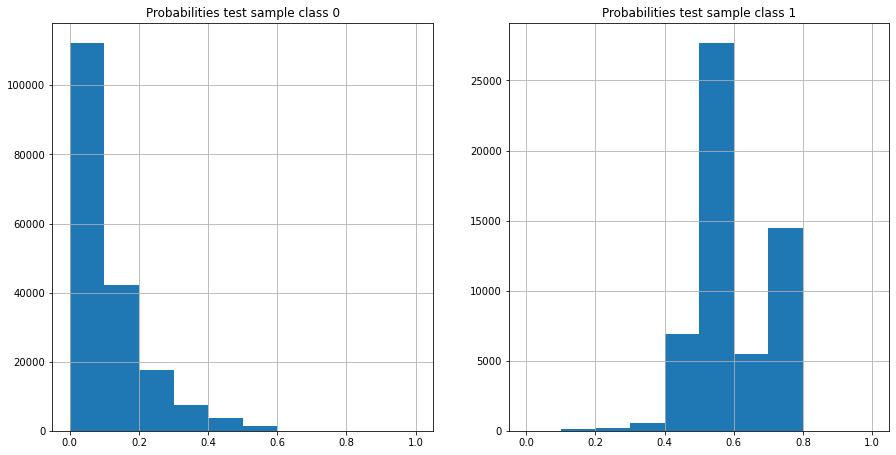

In [13]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Type))]

#Random Forest
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
modelN = 'R Forest'

# Collect results
model.fit(trainX, trainy)
probs = model.predict_proba(testX) #genera array amb la predicció de la probabilitat de ser de cada classe (0 o 1)
probs = probs[:, 1] # Només ens quedem amb les probabilitats de ser de classe 1 (l'altra posició té probabilitat complementària)
#HE DECIDIT UTILITZAR EL VECTOR AMB TOTES LES DADES EN COMPTES DE NOMES ELS DE TEST PER PODER VEURE LA SEPARACIÓ COMPLETA QUE FA
#ANTERIORMENT HO VAIG PROBAR AMB EL TEST (testX i testy) I DONAVA ELS MATEIXOS GRAFICS 

# Separa les probabilitats de ser de classe 1 en les que realment són de classe 1 o 0 (amb l'array testy)
prob_class_0= [P for P,obj_class in zip(probs,testy) if obj_class==0] 
prob_class_1= [P for P,obj_class in zip(probs,testy) if obj_class==1]


fig = plt.figure(frameon=False)
fig.set_size_inches(15,7.5)
plt.xlabel("P")
plt.ylabel("N")

plt.subplot(1,2,1)
plt.hist(prob_class_0, range=(0,1))
plt.grid(True)
plt.title("Probabilities test sample class 0")

plt.subplot(1,2,2)
plt.hist(prob_class_1, range=(0,1))
plt.grid(True)
plt.title("Probabilities test sample class 1")
plt.savefig('Simulation_Prob_NN.jpeg', dpi=300)
p= plt.show()


In [14]:
os.chdir('C:\\Users\\Usuario\\TFG\\FINAL') #tot doble barra quan usem Usuario dins de C

In [15]:
os.getcwd()

'C:\\Users\\Usuario\\TFG\\FINAL'

In [16]:
import joblib
joblib.dump(model, 'model_RF_entrenat.pkl') # Guardo el model

['model_RF_entrenat.pkl']

In [17]:
model = joblib.load('model_RF_entrenat.pkl') # Importa el model entrenat

In [18]:
model.score(testX, testy)

0.9611912343135418

AUC= 0.985


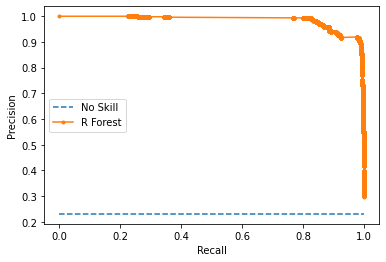

In [19]:
# Position of no-skill curve
no_skill = len(testy[testy==1]) / len(testy)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, probs)

# Calculate AUC
AUC    = auc(recall, precision)
print("AUC= %.3f" % (AUC))

# Plot the P-R curve
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label=modelN)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

R Forest: ROC AUC=0.995


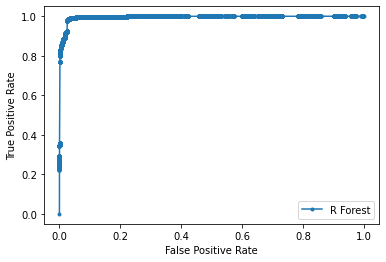

In [20]:
# calculate AUC: no skill and classifier
#ns_AUC = roc_auc_score(testy, ns_probs)
AUC    = roc_auc_score(testy, probs)

# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_AUC))
print(f'{modelN}: ROC AUC=%.3f' % (AUC))

# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
fpr,    tpr,    _ = roc_curve(testy, probs)

# plot the roc curve for the model
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=modelN)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Anem a fer una primera separació del dataset basat en la Neural Network, la probabilitat de tall**

In [21]:
type0 = []
type1 = []
P = 0.5   #PROBABILITAT DE TALL
for i in range(0,len(testX)):
    if probs[i]<P : #seleccionem la probabilitat de tall
        type0.append(testX[i].tolist())
    else:
        type1.append(testX[i].tolist())
        
        '''REVISAR EL GOGtest'''
GOGtest = GOG[GOG.x.isin(testX[:,0])] #Estrelles seleccionades per testejar

MWts = GOGtest[GOGtest['Type'] == 0] #Estrelles de MW de les de test
LMCts = GOGtest[GOGtest['Type'] == 1] #Estrelles de LMC de les de test

print('Estrelles MW Classificador:\t{} \nEstrelles MW Simulació:\t\t{} \nEstrelles LMC Classificador:\t {} \nEstrelles LMC Simulació:\t {}'.format(len(type0),len(MWts),len(type1),len(LMCts)))

Estrelles MW Classificador:	191126 
Estrelles MW Simulació:		184840 
Estrelles LMC Classificador:	 49129 
Estrelles LMC Simulació:	 55415


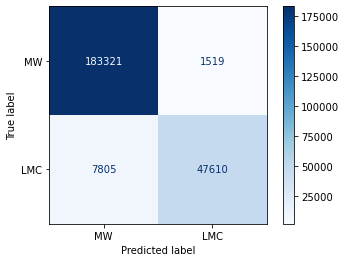

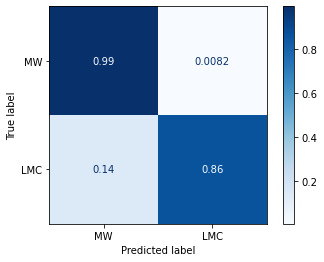

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

os.chdir('C:\\Users\\Usuario\\TFG\\FINAL\\Confu_Matrix') #tot doble barra quan usem Usuario dins de C

np.set_printoptions(precision=6)
probs2 = np.copy(probs)
P = 0.5
for i in range(len(probs)):
    if (probs[i]<P): probs2[i] = 0
    if (probs[i]>=P): probs2[i] = 1
    
confumat = confusion_matrix(testy, probs2)
disp = ConfusionMatrixDisplay(confumat, display_labels= ['MW','LMC'])

disp.plot(cmap=plt.cm.Blues)
plt.savefig('Confu_RF.png', dpi = 300)
#vaig a plotejar una matriu 'normalitzada' que mostri 'Recall' 
#https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

TotalMW = np.sum(confumat[0])
TotalLMC = np.sum(confumat[1])
Nconfumat = np.array([confumat[0]/TotalMW,confumat[1]/TotalLMC])

disp = ConfusionMatrixDisplay(Nconfumat, display_labels= ['MW','LMC'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig('NConfu_RF.png', dpi = 300)

os.chdir('C:\\Users\\Usuario\\TFG\\FINAL') #tot doble barra quan usem Usuario dins de C

#### Exportació Dades a .csv

Genero els dataframes on es guardarà la separació que fa el classificador

In [23]:
tipo0 = pd.DataFrame(type0, columns = ['x','y','mu_x','mu_y','phot_g_mean_mag','BP_RP', 'Varpi'])
tipo1 = pd.DataFrame(type1, columns = ['x','y','mu_x','mu_y','phot_g_mean_mag','BP_RP', 'Varpi'])

In [24]:
#selecciona les que correctament classificades com MW
tipo0cor = MWts[MWts['x'].isin(tipo0.x)]
print('MW correctes:    {}  \t% de MW correcte:    {}%'.format(len(tipo0cor),round(100*len(tipo0cor)/len(tipo0),1)))

#selecciona les que incorrectament classificades com MW
tipo0err = MWts[MWts['x'].isin(tipo1.x)]
print('MW incorrectes:     {}  \t% de MW incorrecte:   {}%'.format(len(tipo0err),round(100*len(tipo0err)/len(tipo0),1)))
 
#selecciona les que correctament classificades com LMC
tipo1cor = LMCts[LMCts['x'].isin(tipo1.x)]
print('LMC correctes:    {}  \t% de LMC correcte:   {}%'.format(len(tipo1cor),round(100*len(tipo1cor)/len(tipo1),1)))

#selecciona les que incorrectament classificades com LMC
tipo1err = LMCts[LMCts['x'].isin(tipo0.x)]
print('LMC incorrectes:    {}  \t% de LMC incorrecte: {}%'.format(len(tipo1err),round(100*len(tipo1err)/len(tipo1),1)))


MW correctes:    183321  	% de MW correcte:    95.9%
MW incorrectes:     1519  	% de MW incorrecte:   0.8%
LMC correctes:    47610  	% de LMC correcte:   96.9%
LMC incorrectes:    7805  	% de LMC incorrecte: 15.9%


In [25]:
#tipo0.to_csv(f'{modelN}_MW_P{P}.csv', index=False)
#tipo1.to_csv(f'{modelN}_LMC_P{P}.csv', index=False)

Llegeixo les dades del classificador per moviment propi

### Comparació dels Classificadors amb la simulació

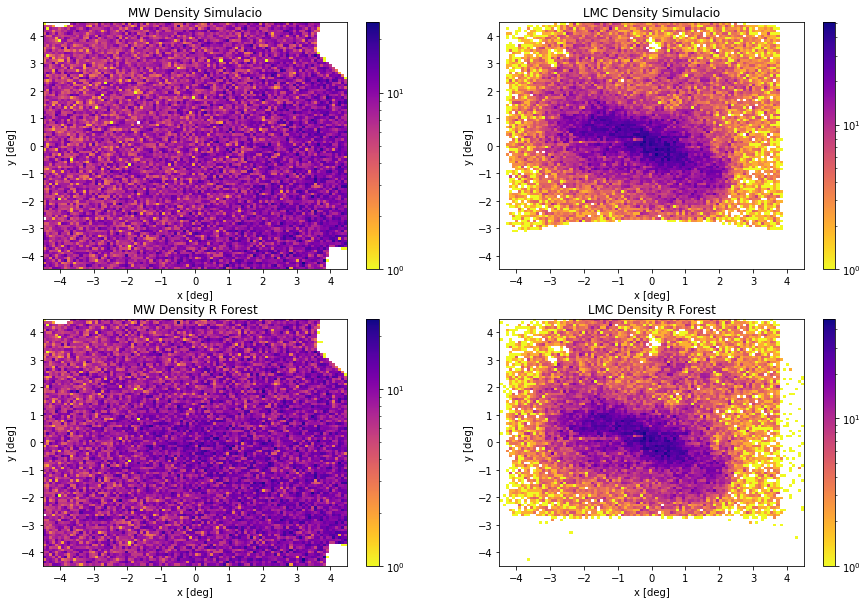

In [26]:
xmin, xmax = -4.5, 4.5
ymin, ymax = -4.5, 4.5
nbins = 100
k=0
 
fig = plt.figure(frameon=False)
fig.set_size_inches(15,10)
dataset=[MWts,LMCts,tipo0, tipo1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    tip=('LMC' if i%2!=0 else 'MW')
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = modelN
    x=dataset[i].x
    y=dataset[i].y
    plt.hist2d(x,y, bins=(nbins,nbins), range=[[xmin,xmax],[ymin,ymax]], cmap = plt.get_cmap('plasma_r'), norm = matplotlib.colors.LogNorm())
    plt.title(f'{tip} Density {clasi}')
    plt.xlabel('x [deg]')
    plt.ylabel('y [deg]')
    plt.colorbar()
plt.show()
#fig.savefig('Comparacio_Densitats_RF.jpg', dpi=300)

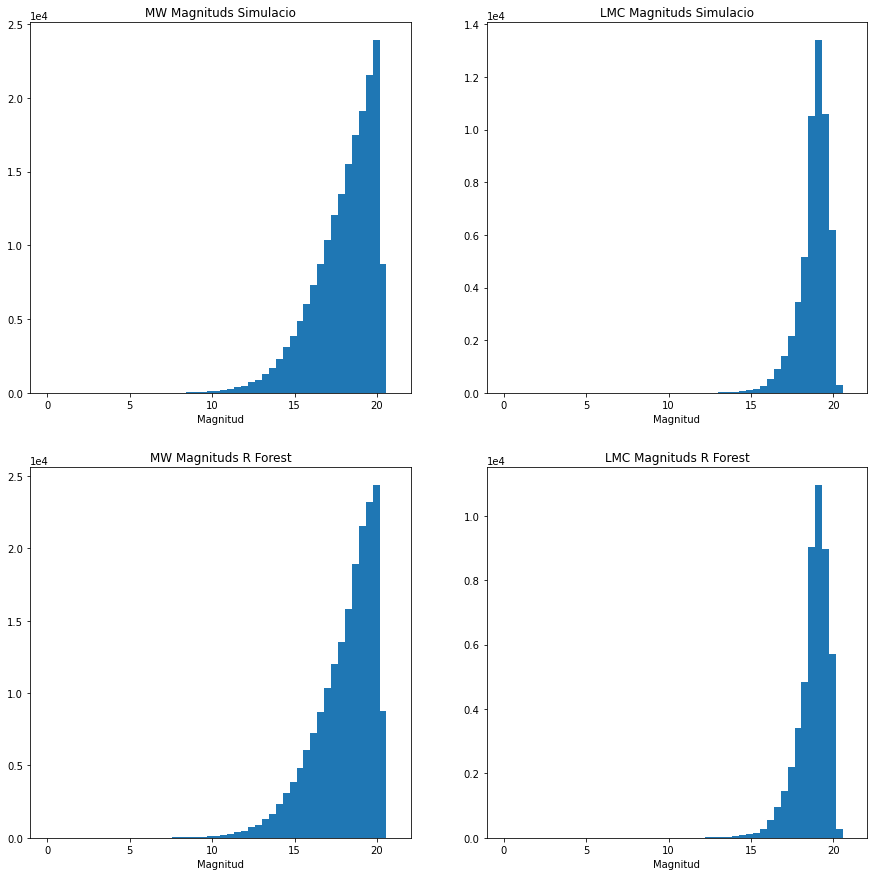

In [27]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,15)
dataset=[MWts,LMCts, tipo0, tipo1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    tip=('LMC' if i%2!=0 else 'MW')
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = modelN
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('Magnitud')
    plt.hist(dataset[i].phot_g_mean_mag, bins = 50, range=[0,21])
    #plt.ylim(0,40000)
    plt.title(f'{tip} Magnituds {clasi}')

plt.show()
#fig.savefig('Comparacio_Magnituds_RF.jpg', dpi=300)

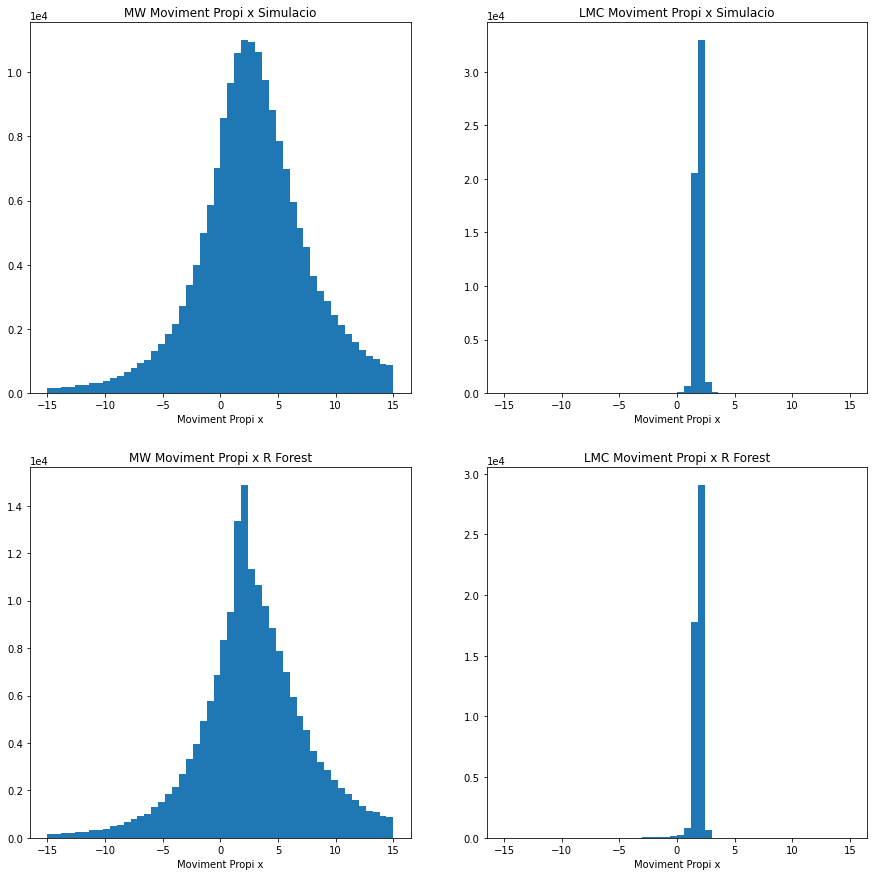

In [28]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,15)
dataset=[MWts, LMCts, tipo0, tipo1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    tip = ('LMC' if i%2!=0 else 'MW')
    rang = ([-15,15] if i%2!=0 else [-15,15]) #rang de millor visualitzacio per LMC: [-3,3]
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = modelN
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('Moviment Propi x')
    #plt.ylim(0,2E5)
    plt.hist(dataset[i].mu_x, bins = 50, range=rang)
    plt.title(f'{tip} Moviment Propi x {clasi}')
plt.show()
#fig.savefig('Comparacio_moviments_x_RF.jpg', dpi=300)

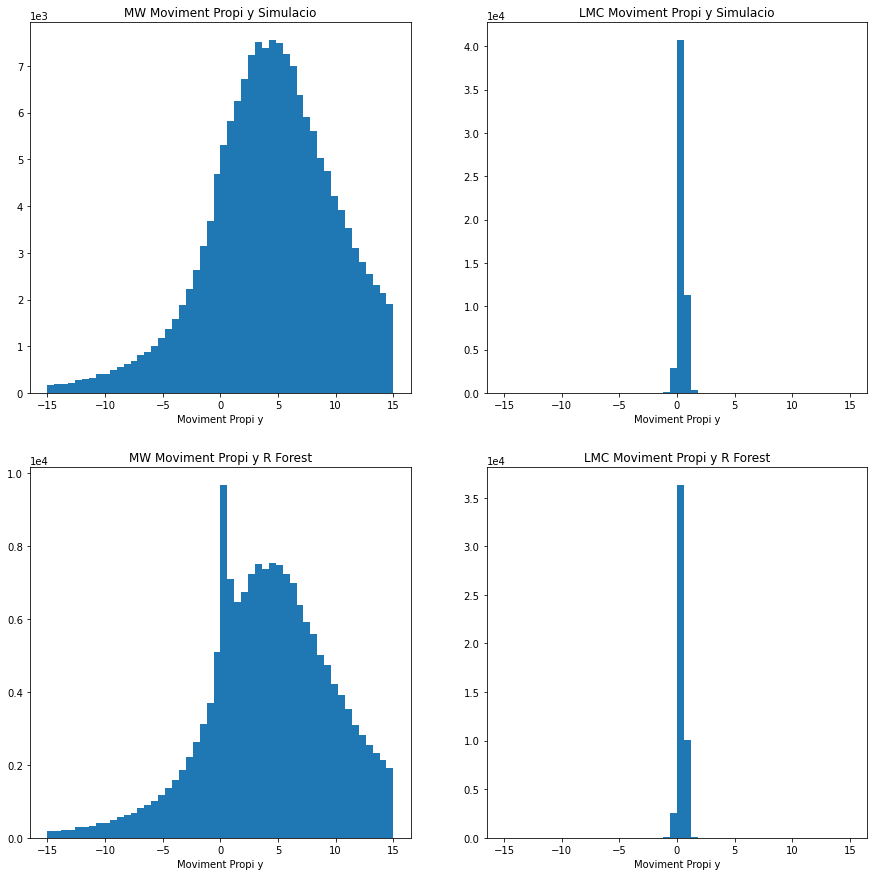

In [29]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,15)
dataset=[MWts,LMCts, tipo0, tipo1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    tip = ('LMC' if i%2!=0 else 'MW')
    rang = ([-15,15] if i%2!=0 else [-15,15]) #rang de millor visualitzacio per MW: [-3,3]
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = modelN
    if (i in (4,5)) : clasi = 'Moviment Propi'
    #plt.ylim(0,2E5)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('Moviment Propi y')
    plt.hist(dataset[i].mu_y, bins = 50, range=rang)
    plt.title(f'{tip} Moviment Propi y {clasi}')
plt.show()
#fig.savefig('Comparacio_moviments_y_NN.jpg', dpi=300)

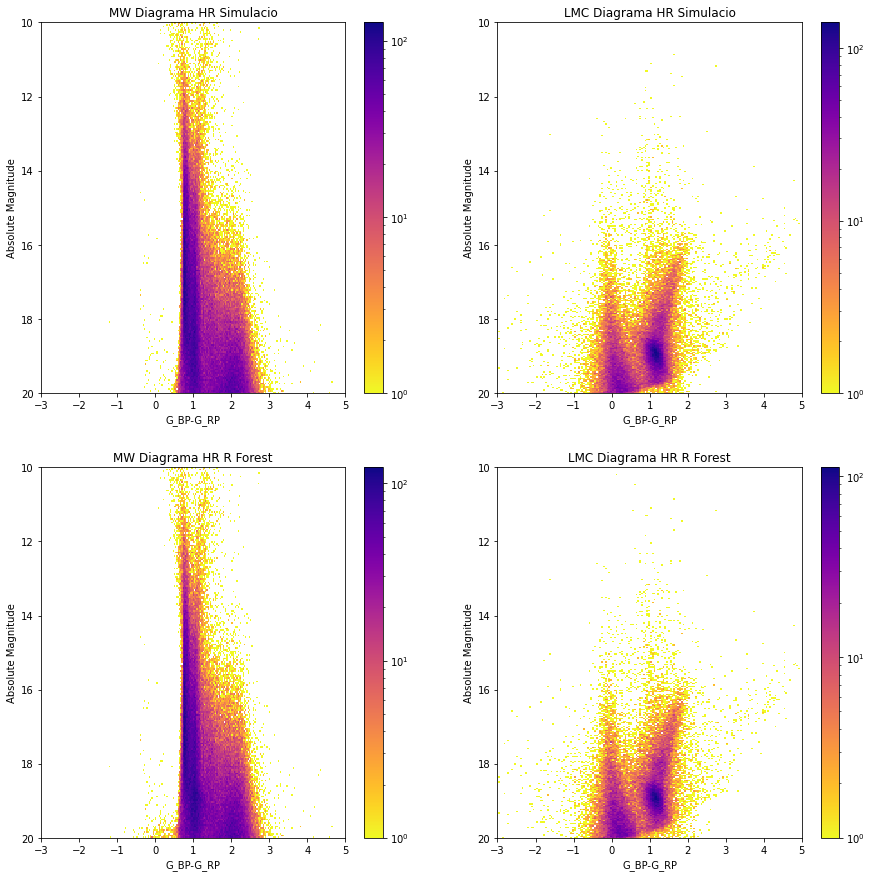

In [30]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,15)
dataset=[MWts, LMCts, tipo0, tipo1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    tip=('LMC' if i%2!=0 else 'MW')
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = modelN
    x=dataset[i].BP_RP
    y=dataset[i].phot_g_mean_mag
    plt.hist2d(x,y,bins=(300,300),cmap = plt.get_cmap('plasma_r'),norm=matplotlib.colors.LogNorm())
    plt.axis([-3,5,20,10])
    plt.xlabel('G_BP-G_RP')
    plt.ylabel('Absolute Magnitude')
    plt.title(f'{tip} Diagrama HR {clasi}')
    plt.colorbar()
plt.show()
#fig.savefig('Comparacio_HR_NN.jpg', dpi=300)

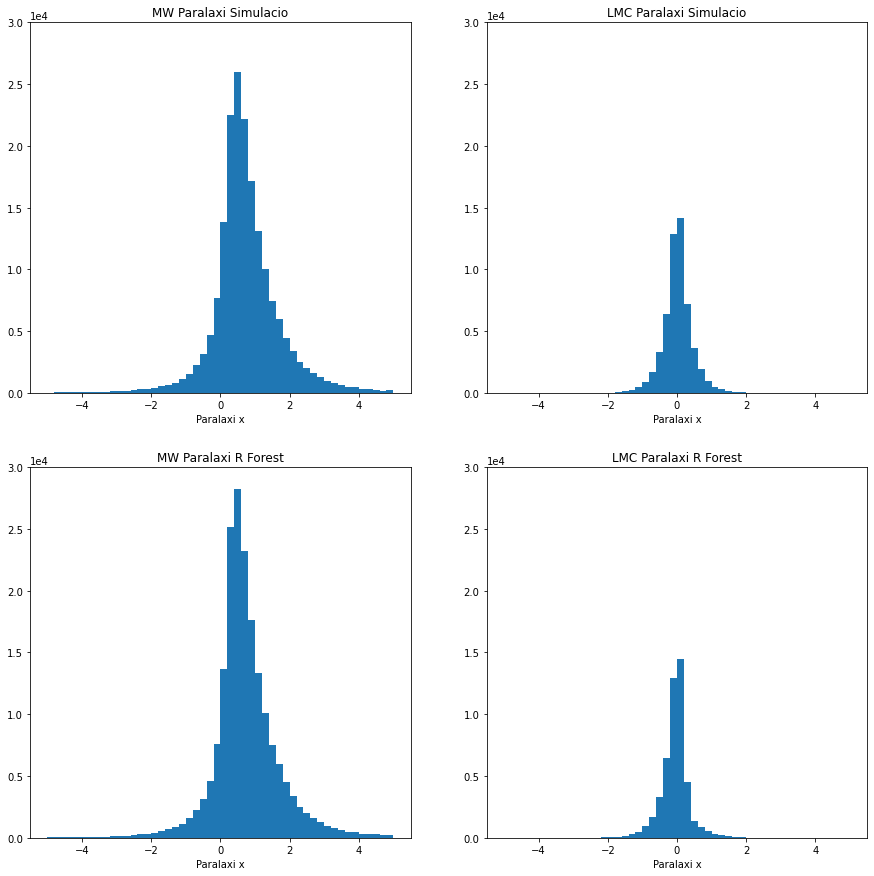

In [31]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,15)
dataset=[MWts,LMCts, tipo0, tipo1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    tip = ('LMC' if i%2!=0 else 'MW')
    rang = ([-5,5] if i%2!=0 else [-5,5]) #rang de millor visualitzacio per LMC: [-3,3]
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = modelN
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('Paralaxi x')
    plt.ylim(0,3E4)
    plt.hist(dataset[i].Varpi, bins = 50, range=rang)
    plt.title(f'{tip} Paralaxi {clasi}')

plt.show()
#fig.savefig('Comparacio_Paralaxi_NN.jpg', dpi=300)

### Aplicar el classificador a dades GAIA

In [32]:
new = 'C:\\Users\\Usuario\\TFG\\FINAL'
os.chdir(new)

In [33]:
model = joblib.load('model_RF_entrenat.pkl') # Importa el model entrenat

In [34]:
new = 'E:\TFG\Dades_Gaia'
os.chdir(new)
GAIA = pd.read_csv('GAIA.csv')

In [35]:
GAIA.columns

Index(['Unnamed: 0', 'source_id', 'phot_g_mean_mag', 'ra', 'dec', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'l', 'b', 'x', 'y', 'mu_x',
       'mu_y', 'BP_RP'],
      dtype='object')

In [36]:
len(GAIA)

15501760

In [37]:
GAIA = GAIA[['source_id','x','y','mu_x','mu_y','phot_g_mean_mag','BP_RP', 'parallax']]

In [38]:
GAIA_list = GAIA.copy()
GAIA_list = GAIA_list.drop(['source_id'], axis=1).to_numpy() #Pasem a array el data

In [39]:
import time
inicio = time.time()
probs = model.predict_proba(GAIA_list)
probs = probs[:,1] #ens quedem amb les probabilitats de ser de classe 1 (LMC)
time.sleep(1)
fin = time.time()
print(fin-inicio) #cONTROLEM EL QUE TRIGA L'EXECUCIÓ  (MOLT LENTA)

64.0732650756836


In [60]:
type0 = []
type1 = []
P = 0.5  #PROBABILITAT DE TALL
for i in range(0,len(GAIA)):
    if probs[i]<P : #seleccionem la probabilitat de tall
        type0.append(GAIA_list[i].tolist())
    else:
        type1.append(GAIA_list[i].tolist())

print('Estrelles MW Classificador:\t{} \nEstrelles LMC Classificador:\t{} \n'.format(len(type0),len(type1)))

Estrelles MW Classificador:	6651854 
Estrelles LMC Classificador:	8849906 



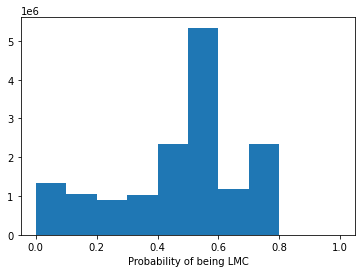

In [61]:
fig = plt.figure(frameon=False)
plt.xlabel('Probability of being LMC')
plt.hist(probs, bins = 10, range=[0,1])
#fig.savefig('Histo_probs_RF.jpg', dpi = 300)
plt.show()

In [62]:
tipo0 = pd.DataFrame(type0, columns = ['x','y','mu_x','mu_y','phot_g_mean_mag','BP_RP', 'parallax'])
tipo1 = pd.DataFrame(type1, columns = ['x','y','mu_x','mu_y','phot_g_mean_mag','BP_RP', 'parallax'])

In [63]:
type0 = None #netegem memoria
type1 = None 

In [64]:
new = 'E:\TFG\Dades_Gaia'
os.chdir(new)
GAIA = pd.read_csv('GAIA.csv')

In [65]:
LMC = GAIA[GAIA['x'].isin(tipo1.x)]
MW = GAIA[GAIA['x'].isin(tipo0.x)]

print('Estrelles classificades com MW:  ', len(MW))
print('Estrelles classificades com LMC:  ', len(LMC))

Estrelles classificades com MW:   6651854
Estrelles classificades com LMC:   8849906


In [66]:
'''
#ho guardem perque triga molt a fer cada classificació (2858s = 47min  38s)
new = 'E:\TFG\Dades_Gaia'
os.chdir(new)
LMC.to_csv('RF_P{}_GAIA_LMC.csv'.format(P))
MW.to_csv('RF_P{}_GAIA_MW.csv'.format(P))
'''

"\n#ho guardem perque triga molt a fer cada classificació (2858s = 47min  38s)\nnew = 'E:\\TFG\\Dades_Gaia'\nos.chdir(new)\nLMC.to_csv('RF_P{}_GAIA_LMC.csv'.format(P))\nMW.to_csv('RF_P{}_GAIA_MW.csv'.format(P))\n"

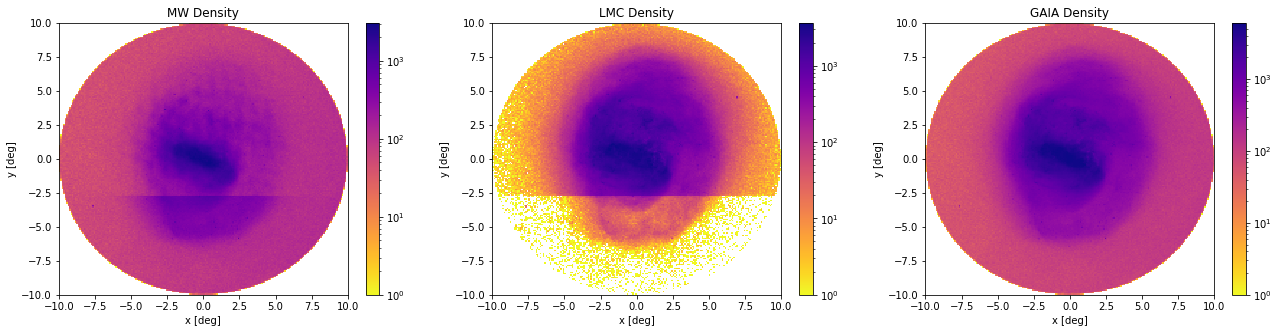

In [67]:
xmin, xmax = -10, 10
ymin, ymax = -10, 10
nbins = 200

fig = plt.figure(frameon=False)
fig.set_size_inches(22,5)
dataset=[MW, LMC, GAIA]
for i in range(0,3):
    plt.subplot(1,3,i+1)
    tip=('LMC' if i%2!=0 else 'MW')
    if i==2: tip='GAIA' 
    x=dataset[i].x
    y=dataset[i].y
    plt.hist2d(x,y, bins=(nbins,nbins), range=[[xmin,xmax],[ymin,ymax]], cmap = plt.get_cmap('plasma_r'),norm=matplotlib.colors.LogNorm())
    #range=[[xmin,xmax],[ymin,ymax]] #afegir a plt.hist2d
    plt.title(f'{tip} Density')
    plt.xlabel('x [deg]')
    plt.ylabel('y [deg]')
    plt.colorbar()
plt.show()
fig.savefig('Densitats_GAIA_RF.jpg', dpi=300)

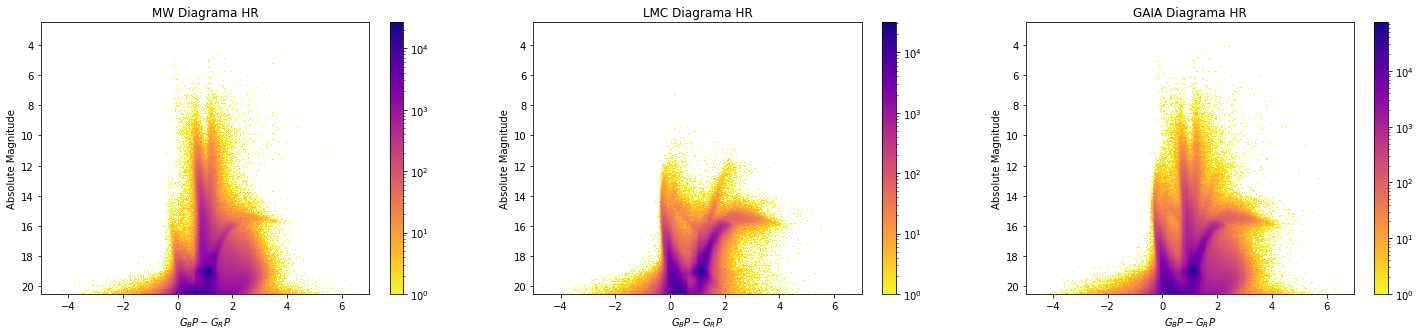

In [68]:
nbins = 300
fig = plt.figure(frameon=False)
fig.set_size_inches(25,5)
dataset=[MW, LMC, GAIA]
for i in range(0,3):
    plt.subplot(1,3,i+1)
    tip=('LMC' if i%2!=0 else 'MW')
    clasi = 'Simulacio'
    if (i in (2,3)) : clasi = 'Moviment Propi'
    if i==2: tip='GAIA'
    x=dataset[i].BP_RP
    y=dataset[i].phot_g_mean_mag
    plt.hist2d(x,y, bins=(nbins,nbins),cmap=plt.get_cmap('plasma_r'),norm=matplotlib.colors.LogNorm())
    plt.axis([-5,7,20.5,2.5])
    plt.xlabel('$G_BP-G_RP$')
    plt.ylabel('Absolute Magnitude')
    plt.title(f'{tip} Diagrama HR')
    plt.colorbar()
plt.show()
fig.savefig('Diagrama_HR_GAIA_RF.jpg', dpi=300)

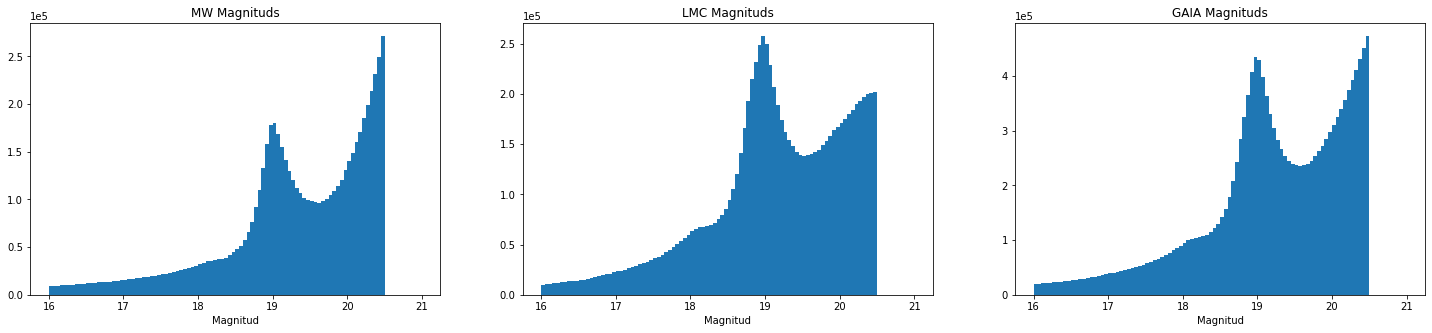

In [69]:
nbins = 100
k=0

fig = plt.figure(frameon=False)
fig.set_size_inches(25,5)
dataset=[MW, LMC, GAIA]
for i in range(0,3):
    plt.subplot(1,3,i+1)
    tip=('LMC' if i%2!=0 else 'MW')
    if i==2: tip='GAIA'
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('Magnitud')
    plt.hist(dataset[i].phot_g_mean_mag, bins = nbins, range=[16,21])
    #plt.ylim(0,5E5)
    plt.title(f'{tip} Magnituds')
plt.show()
fig.savefig('Magnituds_GAIA_RF.jpg', dpi=300)

### Comparació amb altres catàlegs

#### StarHorse

In [70]:
new = 'E:\TFG\Dades_SH'
os.chdir(new)

LMCsh = pd.read_csv('SH_LMC.csv')
MWsh = pd.read_csv('SH_MW.csv')

In [71]:
print('Estrelles StarHorse LMC:  ', len(LMCsh))
print('Estrelles StarHorse MW:  ', len(MWsh))

Estrelles StarHorse LMC:   1028558
Estrelles StarHorse MW:   1564664


In [72]:
#meu intent de fer creuament i comparar resultats
TrueLMC = LMC[LMC['source_id'].isin(LMCsh['source_id'])]
TrueMW = MW[MW['source_id'].isin(MWsh['source_id'])]
print(len(TrueLMC), len(TrueMW))

886750 1007878


#### Cepheids

In [73]:
new = 'E:\TFG\Dades_Cepheids'
os.chdir(new)

cepheids = pd.read_csv('Cef_LMC.csv')
print('Estrelles Cepheids LMC:  ', len(cepheids))

Estrelles Cepheids LMC:   4278


In [74]:
#meu intent de fer creuament i comparar resultats
TrueLMC = LMC[LMC['source_id'].isin(cepheids['source_id'])]
print('Coincidencies amb LMC cepheids: ',len(TrueLMC))

Coincidencies amb LMC cepheids:  4081


#### RR Lyrae

In [75]:
new = 'E:\TFG\Dades_RR'
os.chdir(new)

rrlyrae = pd.read_csv('RR_LMC.csv')
print('Estrelles RR Lyrae LMC:  ', len(rrlyrae))

Estrelles RR Lyrae LMC:   22460


In [76]:
#meu intent de fer creuament i comparar resultats
TrueLMC = LMC[LMC['source_id'].isin(rrlyrae['source_id'])]
print('Coincidencies amb LMC RRLyrae: ',len(TrueLMC))

Coincidencies amb LMC RRLyrae:  14987


Recompte de matches del classificador amb StarHorse

In [77]:
xm_LMC_ultrapurity_SH_LMC = pd.merge(LMC,LMCsh,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])
xm_LMC_ultrapurity_SH_MW = pd.merge(LMC,MWsh,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])
xm_MW_ultrapurity_SH_LMC = pd.merge(MW,LMCsh,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])
xm_MW_ultrapurity_SH_MW = pd.merge(MW,MWsh,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])

xm_LMC_ultrapurity_cepheids = pd.merge(LMC,cepheids,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])
xm_MW_ultrapurity_cepheids = pd.merge(MW,cepheids,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])

xm_LMC_ultrapurity_rrlyrae = pd.merge(LMC,rrlyrae,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])
xm_MW_ultrapurity_rrlyrae = pd.merge(MW,rrlyrae,how='inner',left_on=['ra','dec'], right_on=['ra','dec'])

In [78]:
print ('Number of coincidences XM LMC clean sample (Purity) w/ LMC SH:  '+str(len(xm_LMC_ultrapurity_SH_LMC))+' ('+str(round(len(xm_LMC_ultrapurity_SH_LMC)/len(LMCsh)*100,1))+'%)')
print ('Number of coincidences XM LMC clean sample (Purity) w/ MW SH:  '+str(len(xm_LMC_ultrapurity_SH_MW))+' ('+str(round(len(xm_LMC_ultrapurity_SH_MW)/len(MWsh)*100,1))+'%)')
print ('')
print ('Number of coincidences XM MW clean sample (Purity) w/ LMC SH:  '+str(len(xm_MW_ultrapurity_SH_LMC))+' ('+str(round(len(xm_MW_ultrapurity_SH_LMC)/len(LMCsh)*100,1))+'%)')
print ('Number of coincidences XM MW clean sample (Purity) w/ MW SH:  '+str(len(xm_MW_ultrapurity_SH_MW))+' ('+str(round(len(xm_MW_ultrapurity_SH_MW)/len(MWsh)*100,1))+'%)')
print ('')
print ('')
print ('Number of coincidences XM LMC clean sample (Purity)w/ LMC Cepheids: '+str(len(xm_LMC_ultrapurity_cepheids))+' ('+str(round(len(xm_LMC_ultrapurity_cepheids)/len(cepheids)*100,1))+'%)')
print ('Number of coincidences XM MW clean sample (Purity)w/ LMC Cepheids: '+str(len(xm_MW_ultrapurity_cepheids))+' ('+str(round(len(xm_MW_ultrapurity_cepheids)/len(cepheids)*100,1))+'%)')
print ('')
print ('')
print ('Number of coincidences XM LMC clean sample (Purity)w/ LMC RRLyrae: '+str(len(xm_LMC_ultrapurity_rrlyrae))+' ('+str(round(len(xm_LMC_ultrapurity_rrlyrae)/len(rrlyrae)*100,1))+'%)')
print ('Number of coincidences XM MW clean sample (Purity)w/ LMC RRLyrae: '+str(len(xm_MW_ultrapurity_rrlyrae))+' ('+str(round(len(xm_MW_ultrapurity_rrlyrae)/len(rrlyrae)*100,1))+'%)')

Number of coincidences XM LMC clean sample (Purity) w/ LMC SH:  535008 (52.0%)
Number of coincidences XM LMC clean sample (Purity) w/ MW SH:  338727 (21.6%)

Number of coincidences XM MW clean sample (Purity) w/ LMC SH:  80073 (7.8%)
Number of coincidences XM MW clean sample (Purity) w/ MW SH:  601768 (38.5%)


Number of coincidences XM LMC clean sample (Purity)w/ LMC Cepheids: 4081 (95.4%)
Number of coincidences XM MW clean sample (Purity)w/ LMC Cepheids: 184 (4.3%)


Number of coincidences XM LMC clean sample (Purity)w/ LMC RRLyrae: 14987 (66.7%)
Number of coincidences XM MW clean sample (Purity)w/ LMC RRLyrae: 6332 (28.2%)


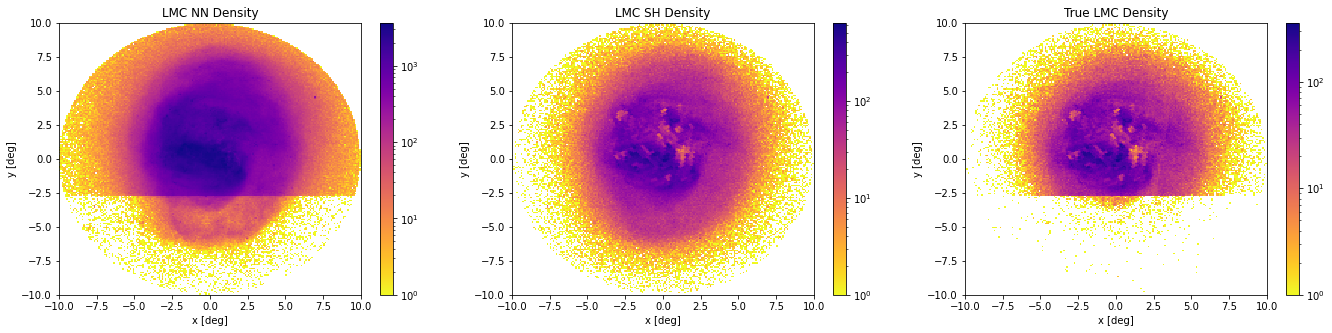

In [79]:
xmin, xmax = -10, 10
ymin, ymax = -10, 10
nbins = 200

fig = plt.figure(frameon=False)
fig.set_size_inches(23,5)
dataset=[tipo1, LMCsh, xm_LMC_ultrapurity_SH_LMC]
for i in range(0,3):
    plt.subplot(1,3,i+1)
    tip=('LMC SH' if i%2!=0 else 'LMC NN')
    
    if i==2: 
        tip='True LMC'
        x=dataset[i].x_x
        y=dataset[i].y_x
    else:
        x=dataset[i].x
        y=dataset[i].y
    plt.hist2d(x,y, bins=(nbins,nbins),range=[[xmin,xmax],[ymin,ymax]], cmap = plt.get_cmap('plasma_r'),norm=matplotlib.colors.LogNorm())
    #range=[[xmin,xmax],[ymin,ymax]] afegir a plt.hist2d
    plt.title(f'{tip} Density')
    plt.xlabel('x [deg]')
    plt.ylabel('y [deg]')
    plt.colorbar()
plt.show()
fig.savefig('Densitats_SH_RF.jpg', dpi=300)